In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.sparse import diags, spdiags
from scipy.linalg import expm
from matplotlib import animation

Запишем общий вид уравнения Шрёдингера

$$H \langle \psi \rangle = E \psi$$

где $\psi$ -- волновая функция, $H$ -- оператор полной энергии (гамильтониан), $E$ -- полная энергия 
системы. Вид гамильтониана

$$H = - \frac{\hbar}{2m} \Delta + U(r)$$

где $\Delta$ -- оператор Лапласа.

Это запись для уравнения Шрёдингера, независимого от времени (стационарного состояния). При записи, 
фактически в правой части мы перешли от оператора, дающего зависимость по времени к величине полной 
энергии. Для того, чтобы записать уравнение, зависящее от времени перейдем к операторам в обеих частях.

$$H \langle \psi \rangle = E  \langle \psi \rangle$$

где $E$ теперь является оператором

$$E = i \hbar \frac{\partial}{\partial t}$$

Теперь уравнение имеет следующий вид

$$i \hbar \frac{\partial \psi(r, t)}{\partial t} = H \langle \psi(r, t) \rangle$$

В этом случае решение дифференциального уравнения можно выразить следующим образом

$$\psi(r, t) = \exp(-i H t) \psi(r, 0)$$

Будем рассматривать распространение волнового пакета вдоль оси $Ox$. Тогда гамильтониан запишем следующим 
образом

$$H = - \frac{\hbar}{2m} \frac{\partial^2}{\partial x^2} + U(x)$$

Для вычисления второй производной воспользуемся формулой вычислительной метематики

$$\frac{\partial^2 f}{\partial x^2} _{x = j \Delta x} = \frac{f_{j+1} - 2f_{j} + f_{j-1}}{dx^2}$$

Тогда, если $f$ представляет собой вектор дискретных значений

$$
\begin{pmatrix}
f_1 \\
f_2 \\
\dots \\
f_N
\end{pmatrix}
$$

То вектор значений вторых происзводных этой функции в узлах построенной сетки можно получить с помощью
трехдиагональной матрицы

$$
\begin{pmatrix}
f_1'' \\
f_2'' \\
\dots \\
f_N''
\end{pmatrix}
= \frac{1}{dx^2}
\begin{pmatrix}
-2 &  1 & 0 & 0     & \dots & 0 & 0 \\
1  & -2 & 1 & 0     & \dots & 0 & 0 \\
0  & 1  &-2 & 1     & \dots & 0 & 0 \\
   &    &   & \dots &       &   &   \\
0  & 0  & 0 & 0     & \dots &-2 & 1 \\
\end{pmatrix}
\begin{pmatrix}
f_1 \\
f_2 \\
\dots \\
f_N
\end{pmatrix}
$$

Значение потенциальной энергии $U$ так же можно представить в виде вектора значений в узлах сетки. Тогда
действие оператора $H$ на вектор значений волновой функции $\psi$ можно представить, как умножение вектора 
значений волновой функции на матрицу

$$
H =
- \frac{\hbar}{2 m dx^2}
\begin{pmatrix}
-2 &  1 & 0 & 0     & \dots & 0 & 0 \\
1  & -2 & 1 & 0     & \dots & 0 & 0 \\
0  & 1  &-2 & 1     & \dots & 0 & 0 \\
   &    &   & \dots &       &   &   \\
0  & 0  & 0 &       & \dots &-2 & 1 \\\end{pmatrix}
\begin{pmatrix}
V_1 &  0  & 0   & 0     & \dots & 0 & 0 \\
0   & V_2 & 0   & 0     & \dots & 0 & 0 \\
0   & 0   & V_3 & 0     & \dots & 0 & 0 \\
    &     &     & \dots &       &   &   \\
0   & 0   & 0   & 0     & \dots & 0 & V_N \\\end{pmatrix}
$$

In [24]:
# return a matrix (like a mtrix operator)
# здесь предполагаем нормировку постоянной планка на 1
# массу частицы m = 1 
def Hamiltonian(N, V_dense, dx):
    L = diags([1, -2, 1], offsets=[-1, 0, 1], shape=(N, N))
    V = spdiags(V_dense, 0, N, N)

    H = - (1 / (2* dx**2)) * L + V
    return H.toarray()

def TimeEvolution(H, dt=1):
    U = expm(-1j*H*dt)
    # задаем точность -- отрубаем слишком малые элементы матрицы
    U[(U.real**2 + U.imag**2) < 1e-10] = 0
    return U

def GaussWavePackage(x, x0, sigma0, p0):
    A = (2*np.pi*sigma0**2)**(-0.25)
    return A*np.exp(1j*p0*x - ((x-x0)/(2*sigma0))**2)

def WaveFunctioProbability(psi):
    return psi.real**2 + psi.imag**2

In [ ]:
'''examples of potential pit'''
# the method is a x function
# use 
# V_dense = np.array([V(x) for x in x_dense])

# box pit
# x -- x range, x0 -- center of pit, d -- width of pit, V0 -- depth
def BoxPotential(x, x0, d, V0):
    if (x <= x0 - d/2 or x >= x0 + d/2):
        return 0
    else:
        return V0

# Oscillator
def ParabolaPotential(x, omega):
    return 0.5 * omega**2 * x**2

In [38]:
x_dense = np.linspace(-20, 50, 1000)
V_dense = np.array([BoxPotential(x, 0, 4, -10) for x in x_dense])

H = Hamiltonian(1000, V_dense, x_dense[1] - x_dense[0])

[[ 203.67 -101.84    0.   ...    0.      0.      0.  ]
 [-101.84  203.67 -101.84 ...    0.      0.      0.  ]
 [   0.   -101.84  203.67 ...    0.      0.      0.  ]
 ...
 [   0.      0.      0.   ...  203.67 -101.84    0.  ]
 [   0.      0.      0.   ... -101.84  203.67 -101.84]
 [   0.      0.      0.   ...    0.   -101.84  203.67]]


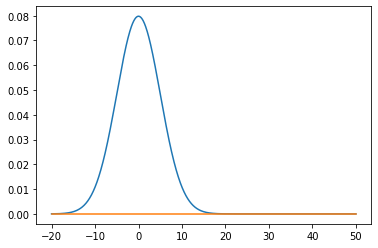

In [34]:
psi = GaussWavePackage(x_dense, 0.0, 5.0, 1.0)
V_dense = np.full(1000, 0.0)
H = Hamiltonian(1000, V_dense, x_dense[1] - x_dense[0])
U = TimeEvolution(H, 1)

# plt.plot(x_dense, GaussWavePackage(x_dense, 0.0, 5.0, 1.0).real)
plt.plot(x_dense, psi.real**2 + psi.imag**2)

In [30]:
from matplotlib import animation

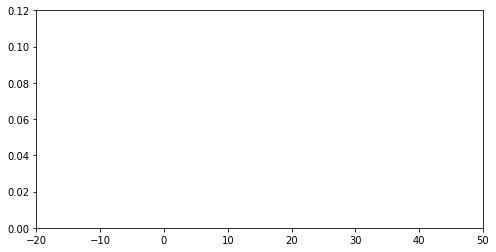

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# don't forget to set an axis limits
ax.set_xlim(-20, 50)
ax.set_ylim(0.0, 0.12)


# next we need to create and initial empty frame
ln1, = plt.plot([], [], label='sin')

# number of frames per second
frm_p_sec = 30

# define the animation function
# this function describe how we will change our frame
# i -- is a number of frame
# it's obvious that the nember of frame consists of time
def animate(i, psi0, U):
    psi = np.linalg.matrix_power(U, i) @ psi0
    # update information about 1st plot
    ln1.set_data(x_dense, psi.real**2 + psi.imag**2)

In [32]:
# here we can geve parametrs to animation function, using a fargs=
ani = animation.FuncAnimation(fig, animate, frames=240, fargs=(psi, U,), interval=frm_p_sec)

In [33]:
# в google collab исполнение заняло 8 мин 54 сек
# 3 мин 24 сек на рабочей машине

# here we can save the animation like a video
f = r"/home/pavel/workfile/Other_things/physics_visualisations/test.mp4" 
writervideo = animation.FFMpegWriter(fps=60) 
ani.save(f, writer=writervideo)